# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать классический перцептрон, немного улучшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [1]:
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [68]:
class Perceptron:
    def __init__(self, iterations=100, l_rate=0.1):
        self.iterations = iterations
        self.l_rate = l_rate
    
    def fit(self, X, y):
        self.w = np.empty(len(X[0])+1)
        for _ in range(self.iterations):
            error = y - self.predict(X)
            dw = np.matmul(error, X)
            self.w = np.add(self.w, self.l_rate * np.insert(dw, 0, sum(error)))
            
    def predict(self, X):
        return 1*(np.matmul(X, self.w[1:]) >= -self.w[0])

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

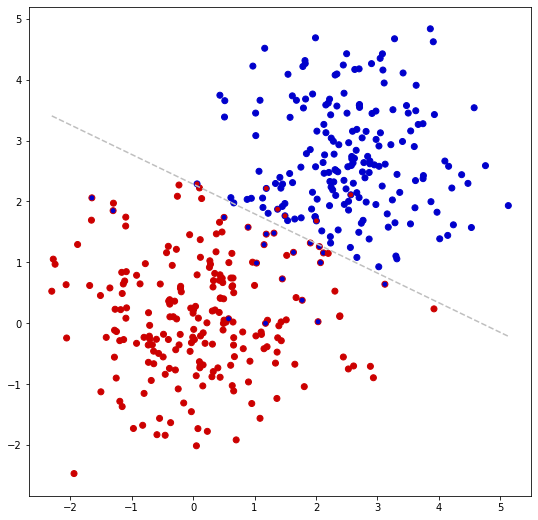

In [75]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

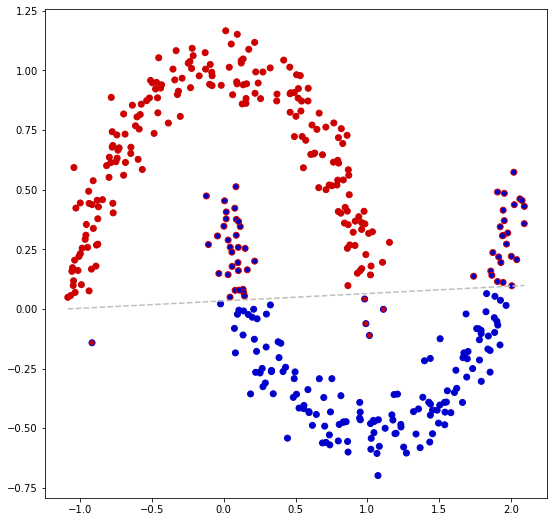

In [76]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

Реализуем перцептрон с карманом.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [86]:
class PerceptronBest(Perceptron):
    def __init__(self, iterations=100, l_rate=0.1):
        super().__init__(iterations, l_rate)
        self.err_min = None
        self.w_best = []
    
    def fit(self, X, y):
        self.w = np.empty(len(X[0])+1)
        for _ in range(self.iterations):
            error = y - self.predict(X)
            dw = np.matmul(error, X)
            self.w = np.add(self.w, self.l_rate * np.insert(dw, 0, sum(error)))
            err_sum = np.matmul(error, error)
            if self.err_min is None or err_sum < self.err_min:
                self.err_min = err_sum
                self.w_best = self.w.copy()
        self.w = self.w_best

In [72]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])  
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")
    
    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

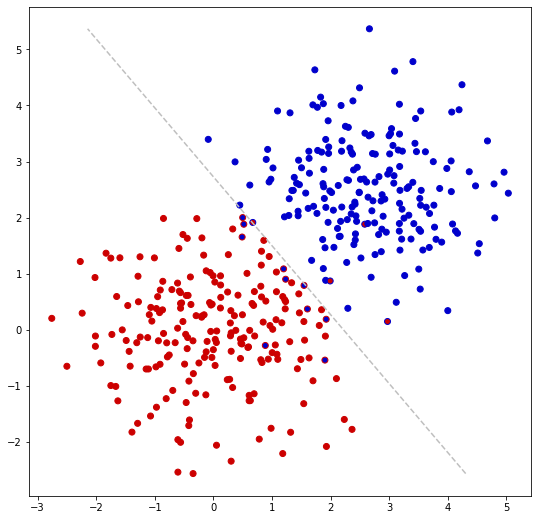

In [87]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

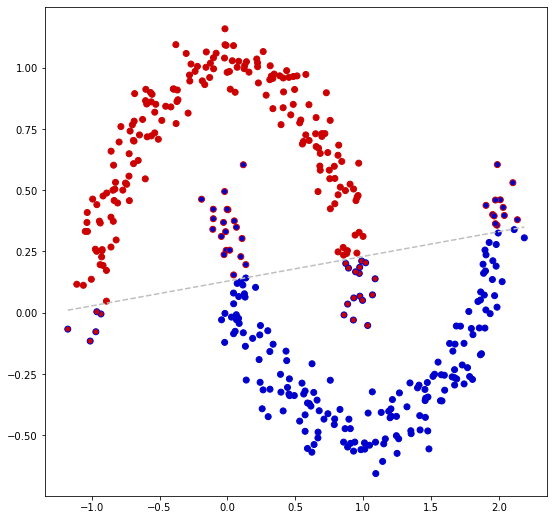

In [88]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [374]:
# import random
from sklearn.decomposition import PCA

def transform_images(images):
    pca = PCA(n_components=2)
    return np.array(pca.fit_transform(list(map(lambda i: i.flatten(), images))))

def get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)

#     for i in random.sample(range(len(images)), k=10):
#         print(labels[i])
#         fig = plt.figure(figsize=(6, 3.2))

#         ax = fig.add_subplot(111)
#         ax.set_title('colorMap')
#         plt.imshow(images[i] > 0.8)
#         ax.set_aspect('equal')

#         cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
#         cax.get_xaxis().set_visible(False)
#         cax.get_yaxis().set_visible(False)
#         cax.patch.set_alpha(0)
#         cax.set_frame_on(False)
#         plt.colorbar(orientation='vertical')
#         plt.show()

    X = transform_images(images)
    return X, labels

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Точность хотя бы одного из классификаторов на тестовой выборке должна быть больше 80%

In [378]:
a = 1
b = 5
X, y = get_digits(a, b)
y = 1*(y == b)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

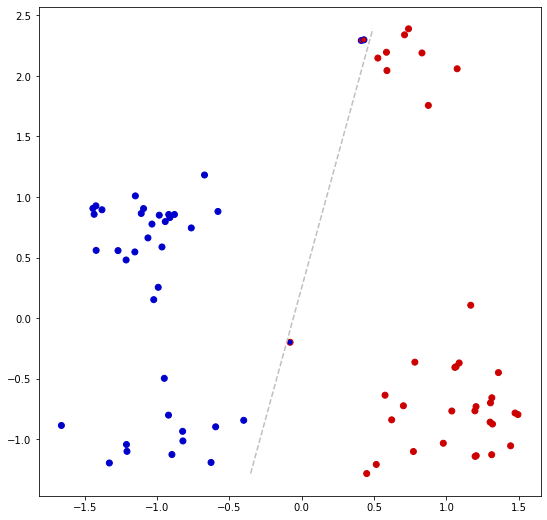

Accuracy: 0.958904109589041


In [379]:
c = Perceptron(iterations=100000)
c.fit(X_train, y_train)
y_pred = c.predict(X_test)
visualize(X_test, y_test, y_pred, c.w)
print("Accuracy:", np.mean(y_pred == y_test))

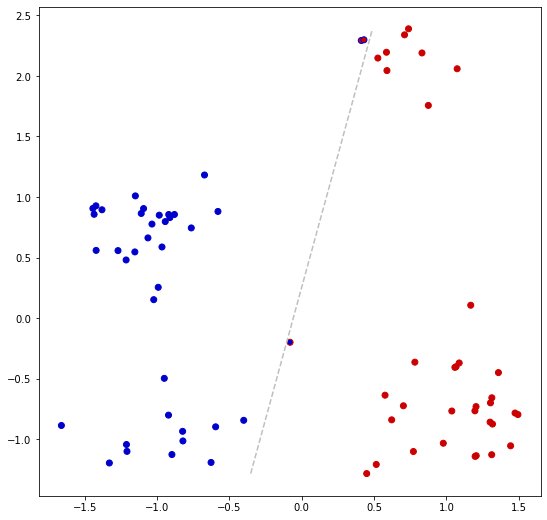

Accuracy: 0.958904109589041


In [380]:
c = PerceptronBest(iterations=100000)
c.fit(X_train, y_train)
y_pred = c.predict(X_test)
visualize(X_test, y_test, y_pred, c.w)
print("Accuracy:", np.mean(y_pred == y_test))

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [381]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    y = 1*(y == y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = Perceptron(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.9499258616131085


In [382]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    y = 1*(y == y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = PerceptronBest(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.9514088079976561
